# RadFil Tutorial
This tutorial walks through all the steps you need in order to build and fit your own radial density profiles. For this tutorial, our filament of choice is the Musca infrared dark cloud, whose density profile has already been analyzed in [Cox et al. 2016](http://www.aanda.org/articles/aa/pdf/2016/06/aa27068-15.pdf) using an independent radial density profile code. We are going to apply RadFil code to the same published column density map used in the Cox et al. 2016 study ("HGBS_musca_column_density_map.fits") which can be downloaded from the Herschel Gould Belt Survey archives [here](http://www.herschel.fr/cea/gouldbelt/en/Phocea/Vie_des_labos/Ast/ast_visu.php?id_ast=66). The data for the tutorial is also stored locally in the Tutorial_Data folder. 

The two basic ingredients we need to build profiles using RadFil is a fits image and a fits mask for your filament. The third is the filament spine, across which we will sample the profile. If you already have an existing spine for your filament (e.g. from DisPerSE) you can input the spine into RadFil. If not, you can ask RadFil to create a spine for you by performing medial axis skeletonization on your inputted mask; this is done via the FilFinder package. Even if you input your own spine, the mask is requisite because RadFil searches for the pixel of maximum column density along each cut, bounded by the mask, and then shifts the profile to the maximum value. This ensures that your resulting profile is always centered at r=0 pc. Let's get started! 

First, we are going to read in our fits image and fits mask (created by applying a simple 2-sigma contour to the fits image) via astropy. Be sure to read in the header in addition to the image array, as RadFil uses that to determine the image scale. The size of the image array and the mask array must be identical. 

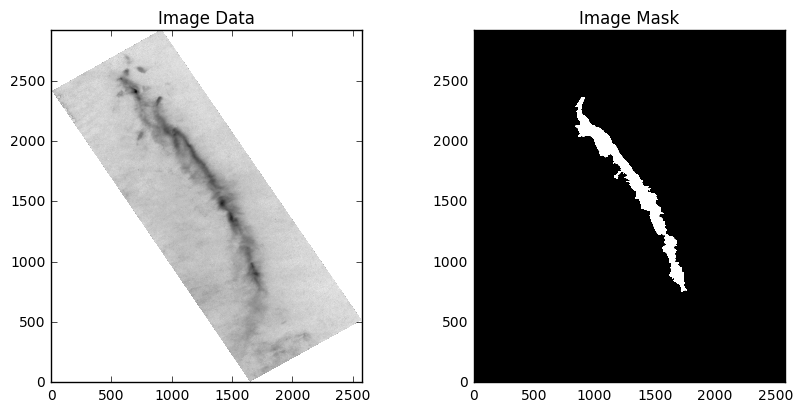

In [5]:
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from radfil import radfil_class
from astropy import units as u
import warnings
import numpy as np

warnings.filterwarnings('ignore')

%matplotlib inline

fil_image,fil_header=fits.getdata("./Tutorial_Data/HGBS_musca_column_density_map.fits", header=True)
fil_image=fil_image
fil_mask=fits.getdata("./Tutorial_Data/Musca_mask.fits")

#plot our image and mask
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax1.imshow(fil_image,origin='lower',cmap='Greys',norm=LogNorm())
ax1.set_title("Image Data")
ax2= fig.add_subplot(222)
ax2.imshow(fil_mask, origin="lower",cmap='Greys_r')
ax2.set_title("Image Mask")
plt.savefig("Image_Mask.png")

Now let's set up our radfil object. The four arguments it expects are an image array (type numpy.ndarray) a mask array of the same shape (type numpy.ndarray), a fits header for the mask data (type astropy.io.fits.Header, read in above via fits.getdata in the cell above), and a distance in pc. We are going to adopt the same distance for Musca adopted in Cox et al. 2016, 200 pc.

In [6]:
radobj=radfil_class.radfil(fil_image, fil_mask, fil_header, 200)

If we wanted to give RadFil a precomputed filament spine, we would provide an additional parameter ("filspine") after the distance, i.e. radfil=fits.getdata("Musca_spine.fits"), that consists of a boolean array of the same shape as fil_image and fil_mask. Instead, we're going to make one using the FilFinder package from Eric Koch and Eric Rosolowsky, which can be downloaded [here](https://github.com/e-koch/FilFinder). They create filament spines by reducing the image mask to a one-pixel wide topological representation of the mask using medial axis skeletonization. The only additional parameter we need to provide FilFinder is the beamwidth of our image in arcseconds, which in Musca's case is 36.3". The verbose argument indicates whether you want FilFinder to output all the skeletonization plots. 

In [7]:
radobj.make_fil_spine(beamwidth=36.3,verbose=False)

Creating the filament spine could take awhile, because the image is very large. Once it's done, your radobj will now have an attribute called filspine, which is the boolean array demarcating the one-pixel wide spine. Once you created your spine the first time, just write it out as a fits image and read it into your radobj object the next time around to avoid having to create the spine again. Here's what the spine looks like: 

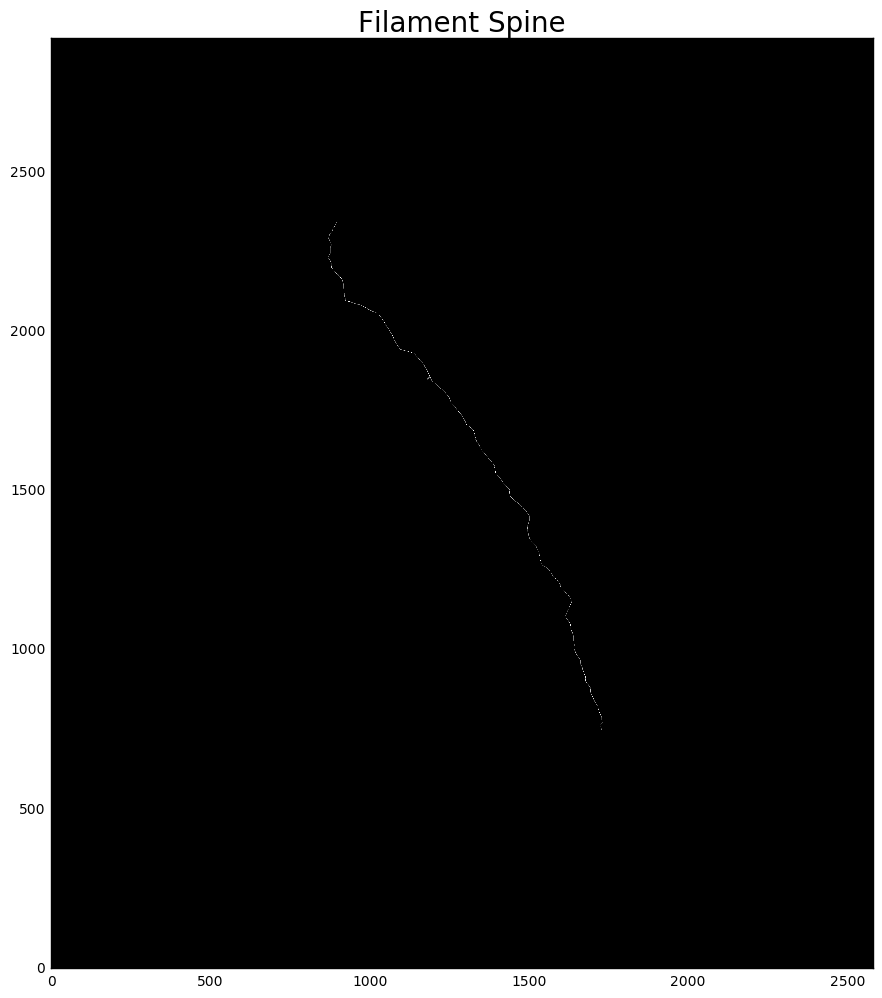

In [15]:
fig=plt.figure(figsize=(12,12))
plt.imshow(radobj.filspine,cmap="binary_r",origin='lower')
fits.writeto("Musca_spine.fits",radobj.filspine, clobber=True)
plt.title("Filament Spine", fontsize=20)

Now that we have everything we need, let's briefly walk through how RadFil builds these profiles. RadFil starts by smoothing the filament spine outputted by the FilFinder program (or DiSperSe), taking the derivative across the spine, and making cuts perpendicular to tangent lines sampled evenly across the smoothed spine. The spine smoothing is necessary because the original spines often do not have a smooth continuous derivative, so perpendicular cuts made locally might not reflect the global curvature of the filament. Smoothing the spines and sampling the cuts is a multi-step process. We start by collecting all pixels in filspine belonging to our original spine and use python’s networkx module to sort the array by the order in which they lie along the spine path. As the filament spines are often non-monotonic, we parameterize them using not only their x and y values, but also this order along the path "t". We then use scipy.interpolate’s splprep function to determine a B-spline representation of the spine, applying a smoothness condition to remove kinks in the original spine. Next, we use scipy.interpolate’s splev function to take the first derivative of the spine and evaluate the local curvature across its entire length. Finally, we make fine cuts across the spine by selecting tangent points at well-sampled intervals, parameterizing the tangent lines at these points, and then taking cuts perpendicular to these tangent lines. 

We build the profiles using the build_profile method, which takes a few optional arguments. The first is the cut distance, which is the distance from the spine out to which you want to sample. The default is 3 pc. Another important parameter, samp_int, determines how finely you'd like to make cuts across the spine. Inputted as an integer, this indicates the approximate distance between cuts in pixels (samp_int=25 means the cuts are ~25 pixels apart, or 25 x imgscale in pc). You can always determine the image scale of your image by typing "radobj.imgscale," and it will return the value in pc. Since radobj.imgscale for Musca=.00387, we are sampling ~ every 0.10 pc here.

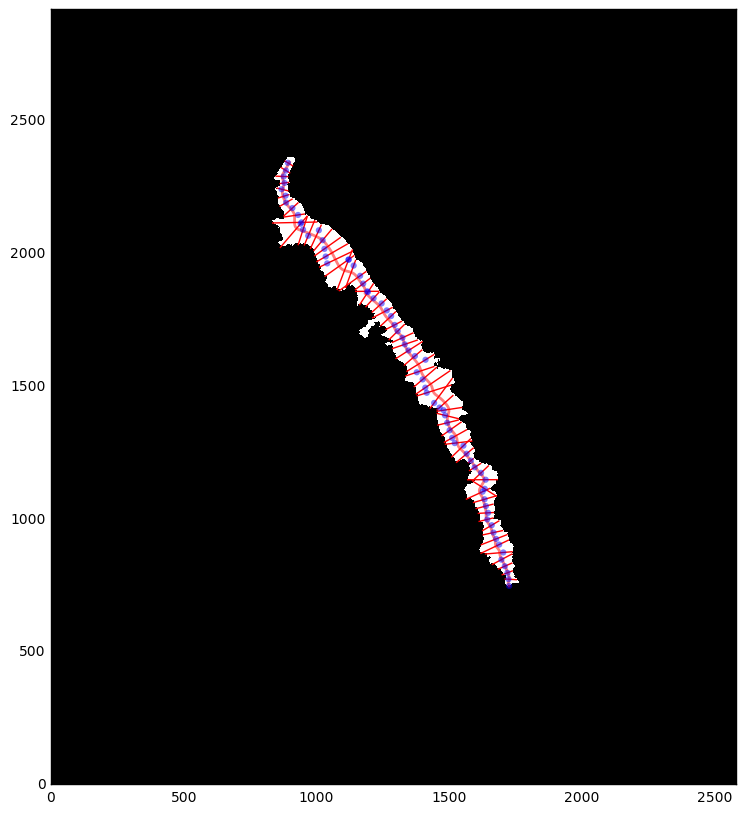

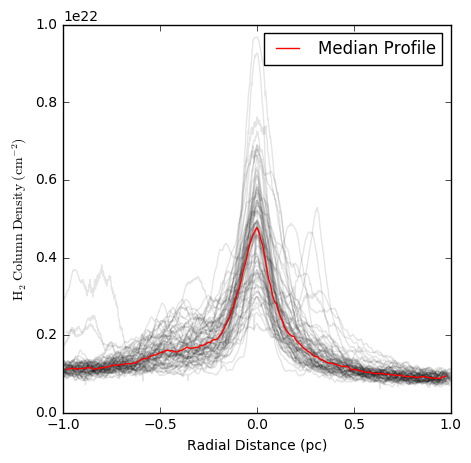

In [9]:
radobj.build_profile(cutdist=1.0,samp_int=25)

The top figure in the above panel shows the smoothed spine as a thick red line running down the original filament mask, with the perpendicular cuts across the spine also shown in red. RadFil searches for the pixel with maximum column density along each of the perpendicular red cuts ("local width lines") which are marked with a blue dot. RadFil then shifts the center of the profile to this pixel, and builds the radial column density profile out from that point.

The bottom profile shows overlays the radial column density profile for each of the red cuts in the top panel. To create the "master" representative profile shown in red, RadFil linearly interpolates between the points in each of the original profiles, bins them by radial distance from the spine, and takes the median column density in each bin. 

Now that we have the master profile, we are reading for fitting using the fit_profile method. RadFil comes with two built in models for fitting: a Gaussian-like model and a Plummer-like model, the latter of which is given in Cox et al. 2016. For both models we can also choose whether we would like to fit a background parameter. If you want to fit your own model, you can do so by inputting your own model (as a function) and parameters (as an lmfit.Parameters) instance. Or, if you just want the master profile to do your own thing with completely outside radfil, you can get those directly by typing "radobj.masterx" and "radobj.mastery" which will return two numpy arrays. For now, we are going to fit both a Plummer-like fit and a Gaussian fit with a built in background.

For the plummer-like fit, we are going to fit out to 1.0 pc, the same fitting distance used in Cox et al. 2016 (private communication). Instead of subtracting of a constant background of ~0.8x10^21 cm^-2, we are going to build it in as part of our fit. Moreover, Cox et al. 2016 exclude the left bump @ 0.5 pc from the fit, while we will include it, which will cause slight deviations from published values. 

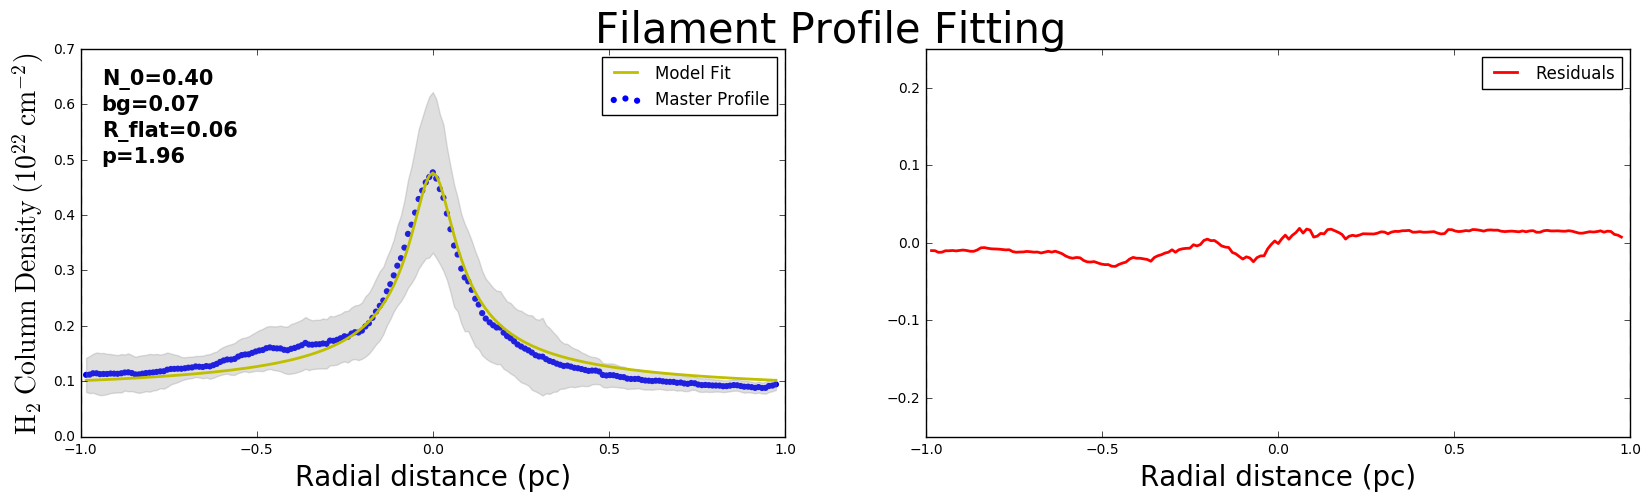

In [10]:
radobj.fit_profile(model="Plummer",fit_bg=True,fitdist=1.0)

The values for R_flat and p given in Cox et al. 2016 are R_flat=0.08 pc, p=2.2 +/- 0.3, while we find R_flat=0.06 and p=1.97, within the margin of errors of the original published values.  

Next, we are going to fit the inner width (i.e. the inner 0.05-0.10 pc) of the filament with a Gaussian, and also include a built-in background parameter, as we did with the Plummer fits. The published Cox et al. 2016 FWHM value is 0.14 +/- 0.03 pc, which will, like the Plummer-like fits, be sensitive to the fitting distance and the estimated background. 

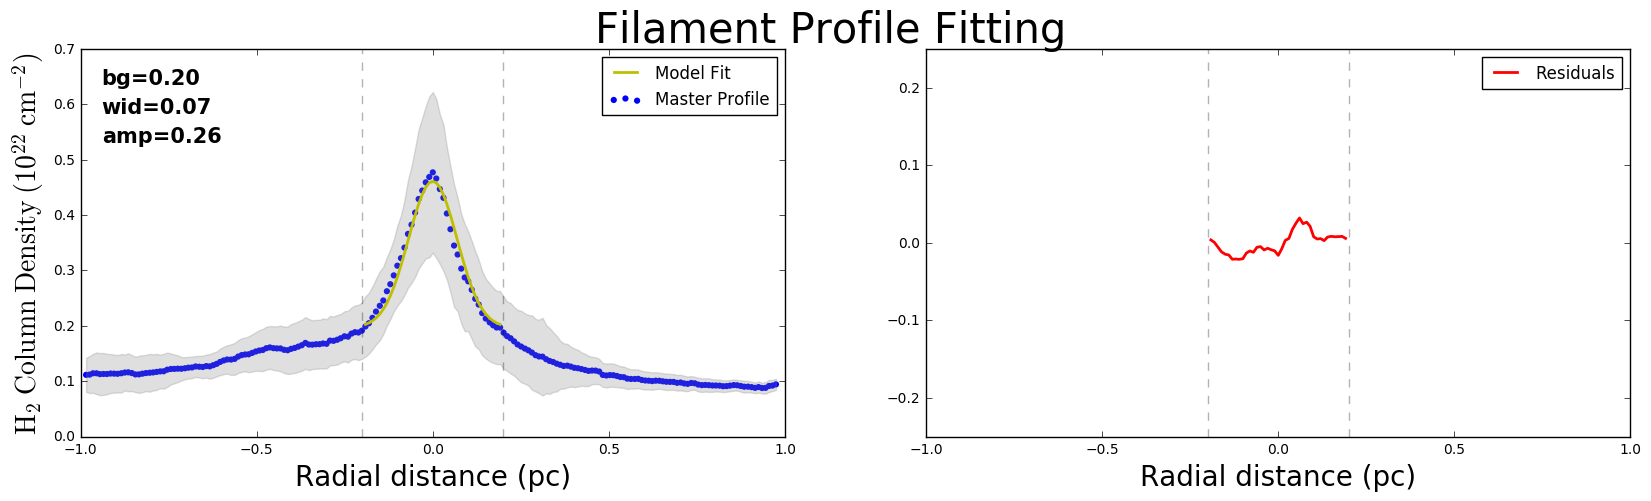

In [21]:
radobj.fit_profile(model="Gaussian",fitdist=0.2,fit_bg=True)

In [23]:
beamwidth=36.3/3600.0 #convert image beam of Musca observations (36.3") to degrees
FWHM = np.sqrt((2.355 * radobj.fit_result.best_values['wid'] ** 2.0 - beamwidth ** 2.0))
print("FWHM={:.2f} pc".format(FWHM))

FWHM=0.11 pc


Deconvolving our best fit width with the beam, we find that our best fit FWHM value is given by 0.11 pc, also in good agreement with the Cox et al. 2016 value. 